In [145]:
import os.path
import skimage.io as io
import sys
import math
import statistics as st
# import opencv
import numpy as np
from matplotlib import pyplot as plt

from skimage.transform import rotate

from skimage.measure import *
from skimage import *

from skimage.transform import probabilistic_hough_line

from skimage.feature import *

from skimage.filters import gaussian
from skimage.morphology import *

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from statistics import *

In [192]:
test_images_path = os.path.join(os.getcwd(), 'test', 'set0')

In [227]:
def load_images(path, n):
    images = []
    suffix = '.png'
    for i in range(n):
        filepath = os.path.join(path, str(i) + suffix)
        images.append(io.imread(filepath, as_gray=True))
    return images

def load_test_ranking(path):
    f = open(os.path.join(path, "correct.txt"), "r")
    img_ranking = [int(a) for a in f.read().split()]
    
    f.close()
    return img_ranking

In [197]:
img_n = 6
img = load_images(test_images_path, img_n)
img_ranking = load_test_ranking(test_images_path)

In [6]:
def entropy(_list):
    return -sum([p * math.log(p) if p > 0 else 0 for p in _list])

In [7]:
def swap(a, b):
    c = a
    a = b
    b = c

In [8]:
def distance(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return round(math.sqrt((x1-x2)**2 + (y1-y2)**2),3)

In [9]:
# usuwa niepotrzebne białe ramki; odpal przykład niżej
# 0 - top, 1 - bottom, 2 - left, 3 - right
def drop_side(arr, side, n = 2): 
    if n <= 0:
        return arr
    
    _arr = arr
    while True:
        x, y = _arr.shape
        if side == 0:
            if n >= x: return _arr
            _to_sum = _arr[n]
            _next   = _arr[1:]
        elif side == 1:
            if n >= x: return _arr
            _to_sum = _arr[-n-1]
            _next   = _arr[:-1]
        elif side == 2:
            if n >= y: return _arr
            _to_sum = _arr[:,n]
            _next   = _arr[:,1:]
        elif side == 3:
            if n >= y: return _arr
            _to_sum = _arr[:,-n-1]
            _next   = _arr[:,:-1]
            
        if np.count_nonzero(_to_sum) == 0:
            _arr = _next
        else:
            return _arr
    
    return arr
    
def drop_empty_borders(arr, n = 2):
    a = drop_side(arr, 0, n)
    b = drop_side(a, 1, n)
    c = drop_side(b, 2, n)
    d = drop_side(c, 3, n)
    return d

In [10]:
t = np.arange(225).reshape((15,15))
t[0:2] = 0
t[-5:] = 0
t[:,0:7] = 0
t[:,-3:] = 0

# print(t)
# print()
# print(dropEmptyBorders(t, 1))

In [11]:
def add_empty_borders(image):
    img_x = image.shape[0]    
    img_y = image.shape[1]
    result = np.zeros((img_x*3, img_y*3))
    _x = int(img_x)  
    _y = int(img_y)
    
    result[_x:_x+img_x, _y:_y+img_y] = image
    return result

In [12]:
def reverse(l):
    a = l
    a.reverse()
    return a

In [13]:
def binarize_image(img):
    return np.where (img>0.0, 1.0, 0.0)

In [14]:
# robi tak fajnie, że obraz ma szerokość X równą podanemu 'n'
def normalise_img_size(img, size = 1024):
    y_scale = size / img.shape[1]
    image_resized = resize(img, (round(y_scale * img.shape[0]), size), anti_aliasing=True)
    image_resized = np.where(image_resized > 0.0, 1.0, 0.0)
    return image_resized

In [15]:
# wyznacza punkt z listy, który jest najbliżej podanego
def nearest_point_to(point, points):
    distance_list = [(distance(point, p), p) for p in points]
    _points = [p for _, p in sorted(distance_list)]
    return _points[0]

In [16]:
# wyznacza kąt między 2 prostymi o wspólnym punkcie p1
def get_angle(p0, p1=np.array([0,0]), p2=None):
    if p2 is None:
        p2 = p1 + np.array([1, 0])
    v0 = np.array(p0) - np.array(p1)
    v1 = np.array(p2) - np.array(p1)

    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    return np.degrees(angle)

In [17]:
def tuple_swap(t):
    a, b = t
    return (b,a)

In [18]:
def angle_between_2_lines(a, b):
    p1, p2 = a
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    a_angle = math.atan2((y1 - y2), (x1 - x2))

    p1, p2 = b
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    b_angle = math.atan2((y1 - y2), (x1 - x2))
    return math.degrees(abs(b_angle - a_angle)) % 90 # 0-90 deg

In [258]:
def take_longest_and_not_parallel_lines(lines):
    treshold = 45 #deg
    lines_ = sorted([(distance(p1,p2), p1, p2) for p1, p2 in lines])
    lines_ = [(p1, p2) for _, p1, p2 in lines_]
    lines_.reverse()
    if len(lines) > 10:
        lines_ = lines_[:int(len(lines_)/10)]
    
    return lines_

    result = []
    while len(lines_) > 0:
        l = lines_[0]
        result.append(l)
        if len(lines_) > 1:
            l1, l2 = l
            l_ = [(p1, p2) for p1, p2 in lines_[1:] if angle_between_2_lines((p1, p2), (l1, l2)) > treshold]
            lines_ = l_
    
    return result

In [259]:
# to nie do końca działa, pewnie w jakimś przypadku będzie trzeba dodać 180; teraz jest tylko poglądowo;
# obraz moze być do góry nogami, ale będzie przynajmniej wyrównany do OX
def degrees_between_line_and_x_axis(p1, p2):
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]

    rotate = 0
    
    return -math.degrees(math.atan2((y1 - y2), (x1 - x2))) + 90 + rotate

In [183]:
def calc_img_determinant(img):
    result = []
    for i in range(img.shape[1]):
        result.append(np.count_nonzero(img[:,i]))
    
    return result

In [260]:
def normalise_vector(v):
    _max = np.max(v)
    
    # zabezpieczenie: jak są wszędzie takie same wartości to się psuje ;__; 
    if np.all(v == _max):
        return v
        
    _min = np.max(v)
    v = [ (x - _min)/(_max - _min) for x in v]
    return v

In [338]:
def get_correctly_rotated_images(images):
    correctly_rotated_images = []

    for image in images:
        image = drop_empty_borders(image, 16)
        image = normalise_img_size(image, 256)
        image_orig = image
        canny_border = canny(image)
        lines = probabilistic_hough_line(canny_border, threshold=32, line_length=16, line_gap=32)
        lines = take_longest_and_not_parallel_lines(lines)
        coords = corner_peaks(corner_harris(image), min_distance=4)

        # punkty jako krotki (x,y)
        points = list(zip(coords[:, 0], coords[:, 1]))

        (p1, p2) = lines[0]
        p = (p1, p2) = (tuple_swap(p1), tuple_swap(p2))

        # kąt do obrotu, też nie zawsze działa, bo trzeba dodać ten przypadek obrotu o 180 jeszcze
        theta = degrees_between_line_and_x_axis(p1, p2)


        fig, ax = plt.subplots()
        plt.imshow(canny_border, cmap=plt.cm.gray)
        plt.plot(coords[:, 1], coords[:, 0], color='red', marker='o', linestyle='None', markersize=5)

        for line in lines[:1]:
            p0, p1 = line
            plt.plot((p0[0], p1[0]), (p0[1], p1[1]), linewidth=4)
        plt.figure()
        plt.show()

        # a tu rysuje po obrocie
        image_orig = rotate(add_empty_borders(image_orig), theta)
        image_orig = drop_empty_borders(image_orig,1) 
        image_orig = normalise_img_size(image_orig, 256)
        image_orig = image_orig[2:-2, 2:-2]
        image_orig = opening(closing(image_orig, disk(3)), disk(3))

        #mockup
        if np.count_nonzero(image_orig[-16]) < (image_orig.shape[1]*0.75):
            image_orig = rotate(image_orig, 180)

        correctly_rotated_images.append(image_orig)

    return correctly_rotated_images


In [239]:
def cut_image_bottom(image):
    while True:
        if np.count_nonzero(image[-1]) == image.shape[1]:
            image = image[:-1]
        else:
            break
    return image

def cut_images_to_the_same_height(images):
    heights = []
    for image in images:
        heights.append(cut_image_bottom(image).shape[0])
        
    expected_height = np.min(heights)
    result = [img[:expected_height] for img in images]
    return result


In [256]:
# rot_images = get_correctly_rotated_images(img)
# cut_images = cut_images_to_the_same_height(rot_images)

# for image in cut_images:
#     plt.imshow(image, cmap=plt.cm.gray)
#     plt.figure()
#     plt.show()

In [257]:
def count_zeros_in_columns(img):
    return list(np.sum(img == 0, axis=0))

def count_zeros_in_image(img):
    return np.sum(img == 0)

# xx = np.array([[0,0,0,0,0,0], [0,1,0,1,1,1], [1,1,1,1,0,1], [1,1,1,1,1,1], [0,1,1,1,1,1]])
# yy = np.array([[0,0,0,1,1,1], [0,0,0,1,1,1], [0,0,1,1,1,1], [0,1,1,1,1,1], [0,1,1,1,1,1]])
# zz = np.array([[0,0,0,1,1,0], [0,0,0,1,1,0], [0,0,1,1,1,0], [0,1,1,1,0,0], [0,1,1,1,1,0]])

# for i in [xx, yy, zz]:
#     det = count_zeros_in_columns(i)
#     print(det)
    
#     print(normalise_vector(det))
#     print("średnia  :", np.mean(det))
#     print("dewiacja :", stdev(det))
#     det = normalise_vector(det)
#     print("entropia :", entropy(det))
#     print()

In [207]:
def get_ranking(cut_images):
    results = []
    for i in range(len(cut_images)):
        determinants = []
    #     print("For image no. ", i)
        current_image = img_as_int(cut_images[i])
        np.where(current_image > 0, 1, 0)
        for j in range(len(cut_images)):
            if i != j:
    #             print(" -> image no. ", j)
                _image = img_as_int(rotate(cut_images[j], 180))
                np.where(_image > 0, 1, 0)
                images_result = (current_image + _image) - (current_image * _image)
                determinants.append((stdev(count_zeros_in_columns(images_result)), j))
    #             plt.imshow(images_result, cmap=plt.cm.gray)
    #             plt.figure()
    #             plt.show()
        result = [img for _, img in sorted(determinants)]
        results.append(result)
    return results
    return 

In [318]:
def grade(result, test_set):
    points = []
    for i in range(len(result)):

        p = 1 / (result[i].index(test_set[i]) + 1)
        points.append(p)
        
        print("{} pkt. -- correct: {}, given ranking: {}".format(round(p, 3), test_set[i], result[i][:5]))
    _sum = np.sum(points)
    print("Total: {} pkt. ({}%)".format(round(_sum, 3), round(_sum / len(points) * 100),3))
    return points

In [319]:
def print_ranking_to_file():
    pass

In [336]:
test_images_path = os.path.join(os.getcwd(), 'test', 'set3')
img_n = 20

def main():
    if len(sys.argv) != 3:
        print("Invalid number of args! Abort.")
        exit()

#     _, path, n = sys.argv
    path, n = test_images_path, img_n

    img = load_images(path, int(n))
    img_ranking = load_test_ranking(path) # test only
    
    rot_images = get_correctly_rotated_images(img)
    cut_images = cut_images_to_the_same_height(rot_images)
    ranking = get_ranking(cut_images)
    
    grade(ranking, img_ranking)
    

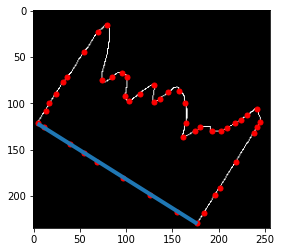

<Figure size 432x288 with 0 Axes>

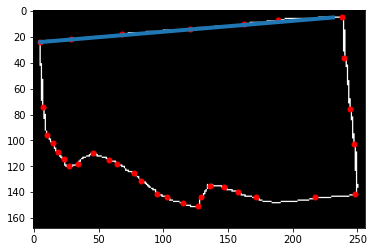

<Figure size 432x288 with 0 Axes>

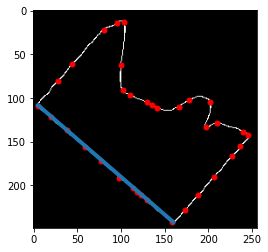

<Figure size 432x288 with 0 Axes>

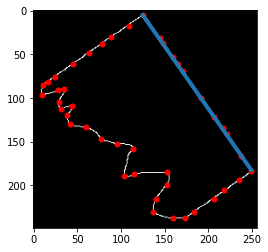

<Figure size 432x288 with 0 Axes>

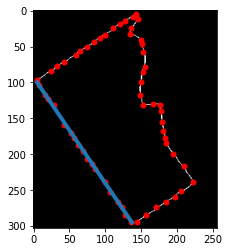

<Figure size 432x288 with 0 Axes>

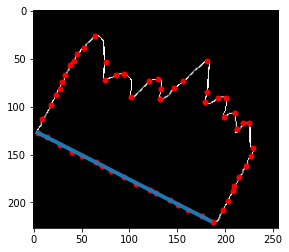

<Figure size 432x288 with 0 Axes>

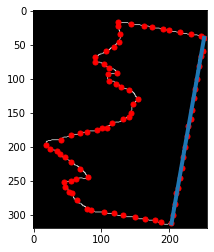

<Figure size 432x288 with 0 Axes>

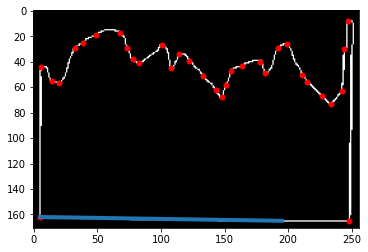

<Figure size 432x288 with 0 Axes>

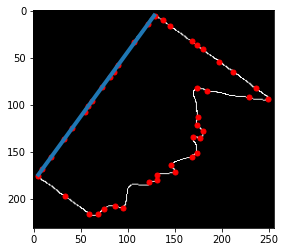

<Figure size 432x288 with 0 Axes>

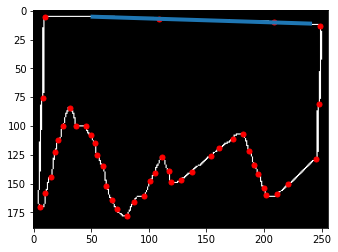

<Figure size 432x288 with 0 Axes>

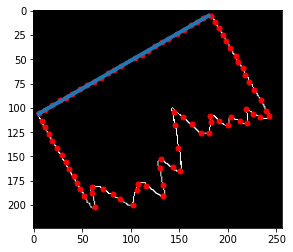

<Figure size 432x288 with 0 Axes>

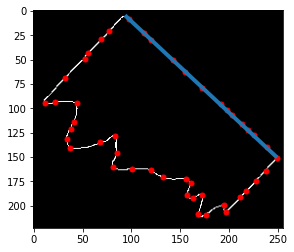

<Figure size 432x288 with 0 Axes>

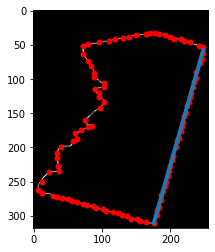

<Figure size 432x288 with 0 Axes>

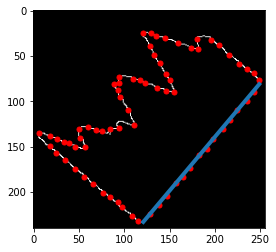

<Figure size 432x288 with 0 Axes>

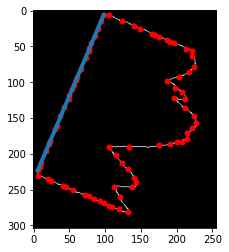

<Figure size 432x288 with 0 Axes>

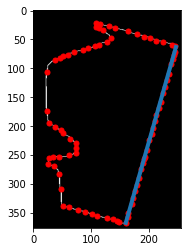

<Figure size 432x288 with 0 Axes>

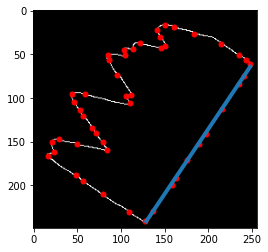

<Figure size 432x288 with 0 Axes>

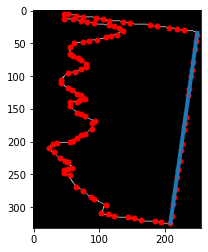

<Figure size 432x288 with 0 Axes>

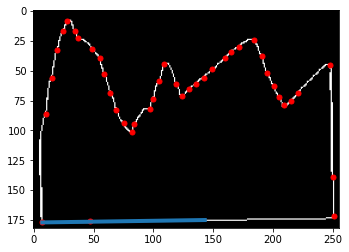

<Figure size 432x288 with 0 Axes>

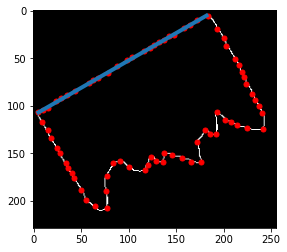

<Figure size 432x288 with 0 Axes>

1.0 pkt. -- correct: 17, given ranking: [17, 12, 10, 7, 1]
1.0 pkt. -- correct: 4, given ranking: [4, 12, 19, 10, 7]
1.0 pkt. -- correct: 15, given ranking: [15, 1, 11, 10, 9]
1.0 pkt. -- correct: 11, given ranking: [11, 10, 15, 17, 9]
1.0 pkt. -- correct: 1, given ranking: [1, 19, 7, 12, 8]
1.0 pkt. -- correct: 10, given ranking: [10, 13, 3, 2, 17]
0.5 pkt. -- correct: 14, given ranking: [19, 14, 8, 1, 7]
1.0 pkt. -- correct: 19, given ranking: [19, 1, 8, 14, 12]
1.0 pkt. -- correct: 12, given ranking: [12, 7, 10, 6, 1]
1.0 pkt. -- correct: 18, given ranking: [18, 1, 10, 19, 3]
1.0 pkt. -- correct: 5, given ranking: [5, 1, 16, 3, 18]
1.0 pkt. -- correct: 3, given ranking: [3, 2, 10, 17, 12]
0.333 pkt. -- correct: 8, given ranking: [1, 19, 8, 14, 0]
1.0 pkt. -- correct: 16, given ranking: [16, 1, 19, 12, 3]
0.25 pkt. -- correct: 6, given ranking: [12, 7, 1, 6, 19]
1.0 pkt. -- correct: 2, given ranking: [2, 3, 19, 10, 12]
0.5 pkt. -- correct: 13, given ranking: [10, 13, 1, 12, 7]
1.0 pk

In [339]:
main()